#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построем модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План выполнения проекта:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Количество заказов находится в столбце `num_orders`.

Установим необходимый функционал и импортируем нееобходимые библиотеки.

In [2]:
!pip install phik -q

In [3]:
!pip install scikit-learn==1.3.2 -q

In [4]:
!pip install missingno -q

In [5]:
# импортируем все необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import missingno as msno
from sklearn.inspection import permutation_importance
import phik
from numpy import quantile
from sklearn.dummy import DummyRegressor
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import (mean_squared_error, mean_absolute_error, confusion_matrix,
                             accuracy_score, precision_score, recall_score, r2_score, roc_auc_score, make_scorer)
from statsmodels.tsa.seasonal import seasonal_decompose
RANDOM_STATE = 42
TEST_SIZE = 0.1

## Подготовка

Загрузим данные. Приведем дату к нужному формату и сделаем этот столбец индексом.

In [6]:
data = pd.read_csv('/####.csv',parse_dates = [0],
                       index_col = [0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
if data.index.is_monotonic == True:
    print('Данные упорядочены.')
else:
    print('Данные требуется упорядочить.')

Данные упорядочены.


Данные идут по порядку, проведем ресемплирование по одному часу.

In [9]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
print('Начало наблюдений:',data.index.max())
print('Конец наблюдений:',data.index.max())

Начало наблюдений: 2018-08-31 23:00:00
Конец наблюдений: 2018-08-31 23:00:00


### Вывод по подготовке.
В нашем распоряжение упорядоченные данные с первого марта по тридцатьпервое августа 2018г. Далее займемся изучением данных.

## Анализ

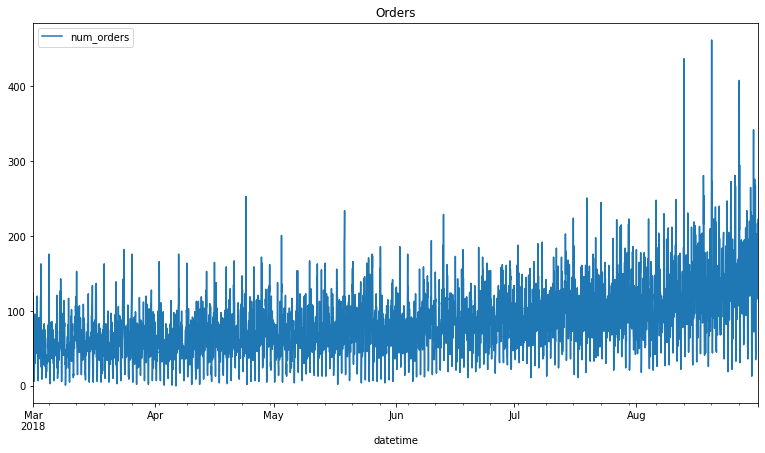

In [11]:
data.plot(figsize=(13,7))
plt.title('Orders')
plt.show()

В таком виде график неинформативен. Произведем декомпозицию, найдем тренд, сезонность для одного дня и остатки.

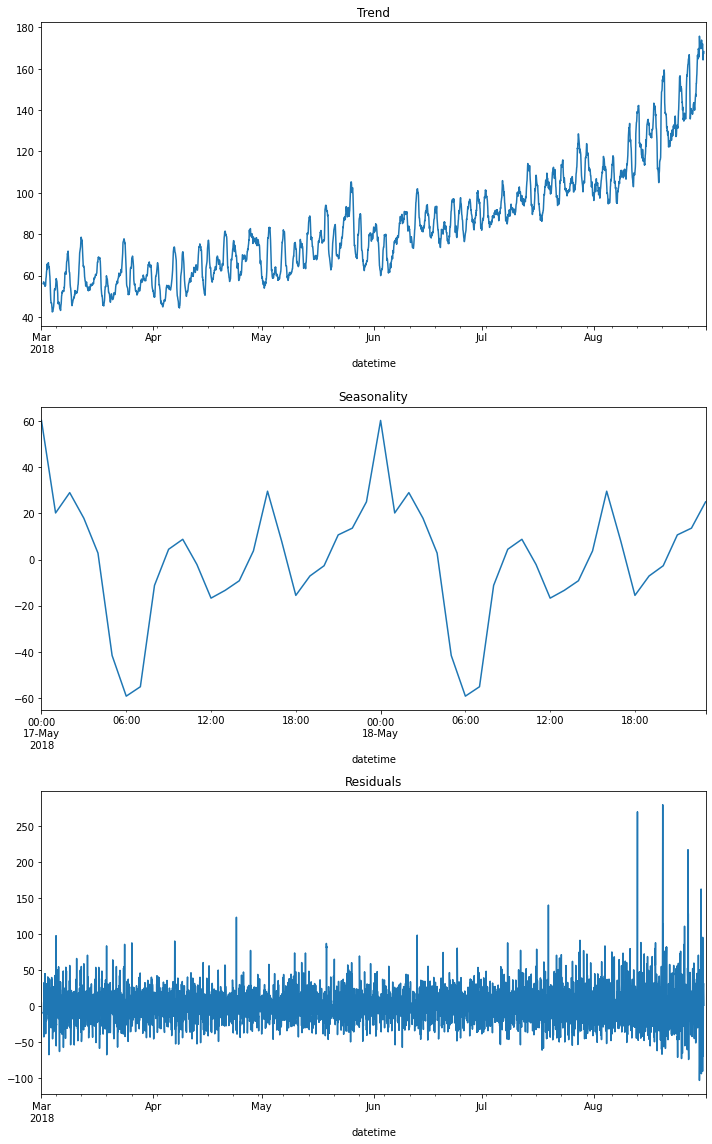

In [12]:
new_data = data.copy()
decompose = seasonal_decompose(new_data)

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decompose.seasonal['2018-05-17':'2018-05-18'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Добавим скользящее среднее и стандартное отклонение.

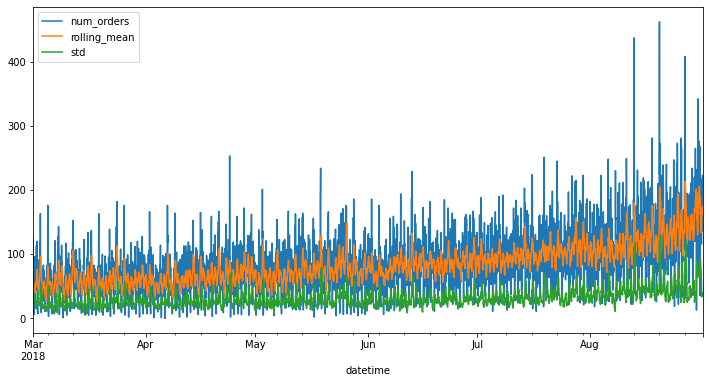

In [15]:
new_data['rolling_mean'] = new_data.rolling(10).mean()
new_data['std'] = new_data['num_orders'].rolling(10).std()
new_data.plot(figsize=(12,6))
plt.show()

### Вывод по анализу.
1. Виден тренд на увеличение общего кол-ва заказов от месяца к месяцу.
2. Самое большое кол-во заказов ночью, это может быть связанно с графиком работы общественного транспорта.
3. Временной ряд нестационарный т.к. среднее значение с стандартное отклонение увеличиваются со времением.

## Обучение

Создадим функцию по добавлению признаков - день, день недели, час, скользящее среднее, скользяшее среднее по дню и неделе, лаги(отстования).

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['day_rolling_sum'] = data['num_orders'].shift().rolling(24).sum()
    data['week_rolling_sum'] = data['num_orders'].shift().rolling(24*7).sum()
    data['lag_24'] = data['num_orders'].shift(24)

    data.dropna(inplace=True)

In [18]:
# добавляем признаки в таблицу
make_features(data,10,10)
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean,day_rolling_sum,week_rolling_sum,lag_24
datetime,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,43.0,74.2,1441.0,9110.0,100.0
2018-03-08 01:00:00,78,3,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,84.2,1484.0,9129.0,121.0
2018-03-08 02:00:00,65,3,2,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,86.9,1441.0,9122.0,24.0
2018-03-08 03:00:00,68,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,88.8,1482.0,9116.0,66.0
2018-03-08 04:00:00,60,3,4,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,90.8,1484.0,9118.0,73.0


Разделим датасет на тестовую и тренировочные выборки, затем проверим корректность разделения данных.

In [16]:
# разделение датасета
train, test = train_test_split(data, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [17]:
print(X_train.shape, X_train.index.min(), X_train.index.max())

(3823, 16) 2018-03-08 00:00:00 2018-08-14 06:00:00


In [18]:
print(X_test.shape, X_test.index.min(), X_test.index.max())

(425, 16) 2018-08-14 07:00:00 2018-08-31 23:00:00


Данные разделены правильно.

In [19]:
# кросвалидация для временных рядов
tscv = TimeSeriesSplit(n_splits=5)

Теперь создадим функцию, которая принимает тестовые и тренировочные данные, словарь с гиперпараметрами модели и саму модель. На выходе получим гиперпараметры лучшей модели, метрику RMSE на тренировочных и тестовых данных.

In [20]:
def create_model2(X_train, X_test, y_train, y_test, param_grid, model):
   
   
    randomized_search = RandomizedSearchCV(
    model,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_iter = 4,
    n_jobs = -1,
    refit=False    
    )
    
    randomized_search.fit(X_train, y_train)
    
    best_params = randomized_search.best_params_
    print('Лучшие параметры:\n\n', best_params)
    
    best_model = model.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    print('Метрика RMSE лучшей модели на тренировочной выборке:', 
          mean_squared_error(y_train, best_model.predict(X_train), squared=False))
    
    y_test_pred = best_model.predict(X_test)
    print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, y_test_pred, squared=False)}')

In [28]:
def create_model(X_train, X_test, y_train, y_test, param_grid, model):
   
   
    randomized_search = RandomizedSearchCV(
    model,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_iter = 4,
    n_jobs = -1,    
    )
    
    randomized_search.fit(X_train, y_train)
    
    best_params = randomized_search.best_params_
    print('Лучшие параметры:\n\n', best_params)
    
    #   best_model = model.set_params(**best_params)
   # best_model.fit(X_train, y_train)
    rmse = randomized_search.best_score_
    
    print('Метрика RMSE лучшей модели на тренировочной выборке:', rmse*-1)
    
    best_model = randomized_search.best_estimator_
    
    return best_model

In [22]:
# словарь для модели DecisionTreeRegressor()
tree_param_grid = [
        {
        'max_depth': range(2, 5),
        'max_features': range(2, 5),
        'random_state': [RANDOM_STATE]
    }]

In [23]:
# словарь для модели LinearRegression()
linear_param_grid = {'fit_intercept':[True,False], 'copy_X':[True, False]}

In [24]:
# словарь для модели LGBMRegressor()
lgbm_param_grid = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 15, 2),
        'num_leaves' : range(20,70,5),
        'verbose' : [0],
        'random_state' : [RANDOM_STATE],
        'force_col_wise': [True]
        }

Далее обучим разные модели и выберем ту, которая покажет лучший результат на тренировочных данных.

### Модель DecisionTreeRegressor.

In [29]:
tree_model = create_model(X_train, X_test, y_train, y_test, tree_param_grid, DecisionTreeRegressor())
tree_model

Лучшие параметры:

 {'random_state': 42, 'max_features': 3, 'max_depth': 4}
Метрика RMSE лучшей модели на тренировочной выборке: 32.86253861294826


DecisionTreeRegressor(max_depth=4, max_features=3, random_state=42)

### Модель LinearRegression..

In [30]:
linear_model = create_model(X_train, X_test, y_train, y_test, linear_param_grid, LinearRegression())
linear_model

Лучшие параметры:

 {'fit_intercept': False, 'copy_X': True}
Метрика RMSE лучшей модели на тренировочной выборке: 27.69998863599369


LinearRegression(fit_intercept=False)

### Модель LGBMRegressor.

In [31]:
lgbm_model = create_model(X_train, X_test, y_train, y_test, lgbm_param_grid, LGBMRegressor())
lgbm_model

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(force_col_wise=True, max_depth=5, n_estimators=50, num_leaves=65,
              random_state=42, verbose=0)

### Вывод по обучению моделей.
Модель LGBMRegressor показала лучший результат - метрика RMSE на тренировочной выборке: 25.324587239644536 против RMSE = 27.69998863599369 у линейной модели и RMSE = 32.86253861294826 у решающего дерева. Будем использовать LGBMRegressor для предсказаний на тестовой выборке.

## Тестирование

In [32]:
y_test_pred = lgbm_model.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {mean_squared_error(y_test, y_test_pred, squared=False)}')

Метрика RMSE на тестовой выборке: 40.832069043746095


# Общий вывод.
В ходе работы были протестированны три модели: LGBMRegressor, LinearRegression и DecisionTreeRegressor.Модель LGBMRegressor показала лучший результат - метрика RMSE на тренировочной выборке: 25.324587239644536 против RMSE = 27.69998863599369 у линейной модели и RMSE = 32.86253861294826 у решающего дерева. Поэтому использовали LGBMRegressor для предсказаний на тестовой выборке. Метрика RMSE на тестовой выборке: 40.832069043746095. Это удовлетворяет условию задачи RMSE < 48.